## 1.Environment Setup & Imports
Run this first to install necessary libraries, mount your Google Drive, and import packages.

In [ ]:
# === 1.1 Install Dependencies ===
!pip install numpy==1.26.4
!pip install scikit-surprise

: 

In [ ]:
# === 1.3 Import Libraries ===
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

# Define path
data_path = '../datasets/student_grade.csv'

: 

## 2.Data Loading & Preprocessing
This section handles reading the CSV, transforming it from "Wide" to "Long" format, cleaning invalid grades, and filtering specifically for 'INT' courses.

In [ ]:
# Check if file exists
if not os.path.exists(data_path):
    print(f"Error: The file '{data_path}' was not found.")
else:
    print("File found. Loading data...")

    # === 2.1 Load Data ===
    df = pd.read_csv(data_path, low_memory=False)

    # === 2.2 Transform Data (Wide to Long) ===
    id_vars = ['student_id']
    df_long = pd.melt(df, id_vars=id_vars, var_name='course', value_name='grade')

    # === 2.3 Clean Data ===
    # Convert grade to numeric and remove invalid/empty grades
    df_long['grade'] = pd.to_numeric(df_long['grade'], errors='coerce')
    df_long_cleaned = df_long[(df_long['grade'] > 0.0) & (df_long['grade'].notna())].copy()

    # === 2.4 Filter for 'INT' Courses Only ===
    # This ensures the model only learns from INT courses
    df_long_filtered = df_long_cleaned[df_long_cleaned['course'].astype(str).str.startswith('INT')].copy()

    print(f"--- Data Preparation Complete ---")
    print(f"Total records after cleaning: {len(df_long_cleaned)}")
    print(f"Filtered to INT courses only: {len(df_long_filtered)}")
    display(df_long_filtered)


File found. Loading data...
--- Data Preparation Complete ---
Total records after cleaning: 43104
Filtered to INT courses only: 17468


,student_id,course,grade
30174,A246,INT102 WEB TECHNOLOGY,1.5
31446,A632,INT102 WEB TECHNOLOGY,3.0
31447,A086,INT102 WEB TECHNOLOGY,4.0
31448,A662,INT102 WEB TECHNOLOGY,4.0
31449,A066,INT102 WEB TECHNOLOGY,2.5
...,...,...,...
597291,A385,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,3.5
597293,A424,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
597306,A111,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
597308,A627,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5


In [ ]:
df

In [ ]:
unique_course_count = df_long_filtered['course'].nunique()
print(f"Number of unique INT courses: {unique_course_count}")

Number of unique INT courses: 57


In [ ]:
df_long_filtered

## 3.Split Data to train and test set

In [ ]:
# === 3.1 Load Data into Surprise Dataset ===
# Define rating scale (assuming grades are 1.0 to 4.0)
reader = Reader(rating_scale=(1, 4))
data = Dataset.load_from_df(df_long_filtered[['student_id', 'course', 'grade']], reader)

# === 3.2 Split Data ===
trainset, testset = train_test_split(data, test_size=0.30, random_state=42)

## 4.Model Training (SVD)
Here we convert the pandas DataFrame into a Surprise Dataset, split it into training/testing sets, and train the SVD algorithm.

In [ ]:


# === 3.3 Train the Model ===
print("--- Training SVD Model ---")
model = SVD(
    n_factors = 100,
    n_epochs  = 140,
    lr_all    = 0.01,
    reg_all   = 0.05,
    random_state = 42
)
model.fit(trainset)
print("Training complete.")



--- Training SVD Model ---
Training complete.


In [ ]:
model.predict('A458','INT540 SELECTED TOPIC IN INFORMATION TECHNOLOGY : BUSINESS FINANCE AND DATA ANALYTICS')

## 5.Test and evaluate model

In [ ]:
# === 3.4 Evaluate Performance ===
print("\n--- Model Evaluation ---")
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)



--- Model Evaluation ---
RMSE: 0.5614
MAE:  0.4444


In [ ]:
# === 4.1 Predict for Unknown Items ===
print("--- Generating Predictions for all missing pairs ---")
anti_testset = trainset.build_anti_testset()
all_predictions = model.test(anti_testset)

# === 4.2 Helper Function for Top-N ===
def get_top_n(predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions."""
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# === 4.3 Generate Top 5 Recommendations ===
top_n_recommendations = get_top_n(all_predictions, n=5)
print(f"Generated recommendations for {len(top_n_recommendations)} students.")

In [ ]:
# =========================================================
# === Calculate Precision@K and Recall@K ===================
# =========================================================

from collections import defaultdict

# Build Ground Truth:
actual_courses_all = defaultdict(list)
actual_courses_B = defaultdict(list)

for uid, iid, true_r, est, _ in predictions:
    actual_courses_all[uid].append(iid)

    if true_r >= 3.0:  # grade >= B
        actual_courses_B[uid].append(iid)


def precision_recall_at_k(top_n, actual_dict, K=5):
    precisions = []
    recalls = []

    for uid, user_recs in top_n.items():
        recommended_items = [iid for iid, _ in user_recs[:K]]
        actual_items = actual_dict.get(uid, [])

        if len(actual_items) == 0:
            continue

        true_positives = len(set(recommended_items) & set(actual_items))

        precision = true_positives / K
        recall = true_positives / len(actual_items)

        precisions.append(precision)
        recalls.append(recall)

    precision_avg = sum(precisions) / len(precisions)
    recall_avg = sum(recalls) / len(recalls)
    return precision_avg, recall_avg


# --------- Calculate results for K = 5 and 10 -----------
K_values = [5, 10]

print("\n====================== Precision & Recall ======================")

for K in K_values:
    precision_all, recall_all = precision_recall_at_k(top_n_recommendations, actual_courses_all, K)
    precision_B, recall_B = precision_recall_at_k(top_n_recommendations, actual_courses_B, K)

    print(f"\n========== K = {K} ==========")
    print("-- Using ALL enrolled courses --")
    print(f"Precision@{K}: {precision_all:.4f}")
    print(f"Recall@{K}: {recall_all:.4f}")

    print("\n-- Using ONLY courses with grade >= B --")
    print(f"Precision@{K}: {precision_B:.4f}")
    print(f"Recall@{K}: {recall_B:.4f}")

print("===================================================================")


In [ ]:
# === 5.1 Visualization Function ===
def visualize_topk_by_rank(top_n_recommendations, K=5, top_m=10):
    """
    Visualizes the frequency of recommended courses by rank.
    K: Number of recommendations per student.
    top_m: Number of top courses to show in the chart.
    """
    rows = []
    for student_id, recs in top_n_recommendations.items():
        for r, (course, score) in enumerate(recs[:K], start=1):
            rows.append({"rank": r, "course": course})

    if not rows:
        print("No recommendations to visualize.")
        return

    df_viz = pd.DataFrame(rows)
    rank_counters = {r: Counter(df_viz[df_viz["rank"] == r]["course"]) for r in range(1, K+1)}

    for r in range(1, K+1):
        counter = rank_counters[r]
        if not counter: continue

        most_common = counter.most_common(top_m)
        courses = [c for c, _ in most_common]
        counts  = [cnt for _, cnt in most_common]

        plt.figure(figsize=(10, 4))
        plt.bar(courses, counts, color='skyblue')
        plt.title(f"Top {top_m} Courses @ Rank {r}")
        plt.xlabel("Course")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# === 5.2 Run Visualization ===
print("--- Visualization of Recommendations ---")
visualize_topk_by_rank(top_n_recommendations, K=5, top_m=10)

# === 5.3 Create Final DataFrame ===
rows = []
for student_id, recs in top_n_recommendations.items():
    for rank, (course, predicted_grade) in enumerate(recs, start=1):
        # Note: Data was filtered for INT in step 2, so this check is just a safeguard
        if isinstance(course, str) and course.startswith("INT"):
            rows.append({
                "student_id": student_id,
                "rank": rank,
                "course": course,
                "predicted_grade": predicted_grade
            })

df_recommendations = pd.DataFrame(rows)

print("\n--- Final Recommendations Preview ---")
display(df_recommendations.head(15))

## 6.Confusion Matrix

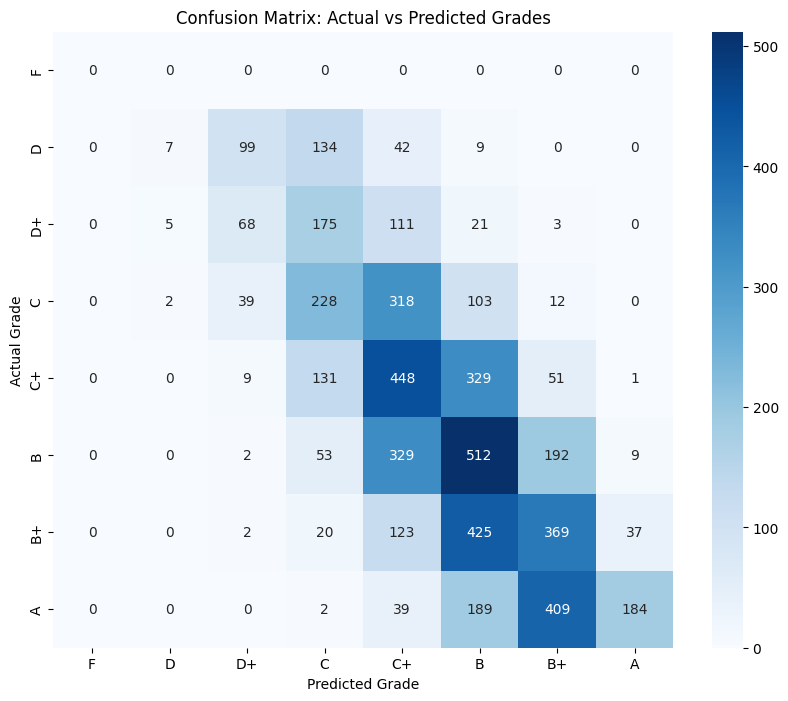


--- Detailed Classification Report ---
              precision    recall  f1-score   support

           F       0.00      0.00      0.00         0
           D       0.50      0.02      0.05       291
          D+       0.31      0.18      0.23       383
           C       0.31      0.32      0.32       702
          C+       0.32      0.46      0.38       969
           B       0.32      0.47      0.38      1097
          B+       0.36      0.38      0.37       976
           A       0.80      0.22      0.35       823

    accuracy                           0.35      5241
   macro avg       0.36      0.26      0.26      5241
weighted avg       0.41      0.35      0.33      5241



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Define Mapping: Score -> Letter
# ต้องเรียงลำดับจากน้อยไปมาก เพื่อให้ Matrix สวยงาม
score_to_letter = {
    0.0: 'F', 1.0: 'D', 1.5: 'D+', 2.0: 'C', 2.5: 'C+',
    3.0: 'B', 3.5: 'B+', 4.0: 'A'
}

# สร้าง list ของเกรดที่เป็นไปได้ (เอาไว้ระบุ Labels)
# กรองเอาเฉพาะที่มีใน map (เผื่อกรณีข้อมูลไม่มี F)
valid_scores = sorted(score_to_letter.keys())
valid_labels = [score_to_letter[s] for s in valid_scores]

# 2. Helper function: หาเกรดที่ใกล้ที่สุด
def get_nearest_grade_key(pred_score):
    # หา key (คะแนน) ที่ใกล้ที่สุด
    return min(valid_scores, key=lambda x: abs(x - pred_score))

# 3. Prepare Data
y_true_letters = []
y_pred_letters = []

for pred in predictions:
    # 3.1 แปลง Actual Grade (r_ui) เป็น Letter
    # ใช้ get_nearest_grade_key เผื่อค่า r_ui มีทศนิยมเพี้ยนเล็กน้อย
    true_score_key = get_nearest_grade_key(pred.r_ui)
    y_true_letters.append(score_to_letter[true_score_key])

    # 3.2 แปลง Predicted Grade (est) เป็น Letter
    pred_score_key = get_nearest_grade_key(pred.est)
    y_pred_letters.append(score_to_letter[pred_score_key])

# 4. Generate Confusion Matrix
# สำคัญ: ต้องใส่ labels=valid_labels เพื่อบังคับลำดับ (D -> A)
cm = confusion_matrix(y_true_letters, y_pred_letters, labels=valid_labels)

# 5. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid_labels,
            yticklabels=valid_labels)

plt.title('Confusion Matrix: Actual vs Predicted Grades')
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.show()

# 6. Classification Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true_letters, y_pred_letters, target_names=valid_labels, zero_division=0,labels=valid_labels))

In [ ]:
y_true_raw = [pred.r_ui for pred in predictions]
y_pred_raw = [pred.est for pred in predictions]

# 2. คำนวณ R2 Score
r2 = r2_score(y_true_raw, y_pred_raw)

print(f"R2 Score: {r2:.4f}")

R2 Score: 0.5692
